In [48]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import HMC,MCMC, NUTS
from torch.autograd import grad
import numpy as np


import matplotlib.pyplot as plt

In [49]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(f'device: {device}')

device: cuda:0


In [50]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )
    def forward(self, t):
        return self.net(t)
    


pinn = PINN()

In [51]:
# sensor data
t_data = torch.linspace(0., 5., 50).unsqueeze(-1)          # [50×1]
u_true = 0.5*t_data**2 + t_data
noise = 0.1
u_data = u_true + noise * torch.randn_like(u_true)

# collocation for PDE residual
t_f = torch.linspace(0., 5., 70).unsqueeze(-1).requires_grad_(True)

# initial condition point
t_ic = torch.tensor([[0.0]], requires_grad=True)

In [53]:
def model(t_data, u_data, t_f, t_ic):

    # Priors over all NN parameters
    priors = {}
    for name, param in pinn.named_parameters():
        priors[name] = dist.Normal(0., 10.).expand(param.shape).to_event(param.dim())

    # create a “randomized” BNN
    bnn = pyro.random_module("bnn", pinn, priors)()

    # 3.2 Sensor‑data likelihood
    sigma_obs = pyro.sample("sigma_obs", dist.Uniform(1e-3, 5.0))
    u_pred = bnn(t_data).squeeze(-1)
    with pyro.plate("data", t_data.shape[0]):
        pyro.sample("obs",dist.Normal(u_pred, sigma_obs),obs=u_data.squeeze(-1))

    # 3.3 Physics residuals: du/dt – t ≈ 0
    # u_f = bnn(t_f)
    # du_dt = torch.autograd.grad(u_f, t_f,
    #                             grad_outputs=torch.ones_like(u_f),
    #                             create_graph=True, allow_unused=None)[0]
    # r_phy = (du_dt.squeeze(-1) - t_f.squeeze(-1))
    # sigma_phy = pyro.sample("sigma_phy", dist.Uniform(1e-3, 1.0))
    # with pyro.plate("physics", t_f.shape[0]):
    #     pyro.sample("phy",
    #                 dist.Normal(r_phy, sigma_phy),
    #                 obs=torch.zeros_like(r_phy))


    # Physics Residuals

    sigma_phy = pyro.sample("sigma_phy", dist.Uniform(1e-3, 5.0))

    # make sure t_f is set up for autograd
    t_f = t_f.detach().requires_grad_(True)
    with torch.enable_grad():
        u_f   = bnn(t_f)                           
        du_dt = torch.autograd.grad(u_f, t_f,grad_outputs=torch.ones_like(u_f),create_graph=True)[0]

    res_pde = (du_dt.squeeze(-1) - t_f.squeeze(-1))

    with pyro.plate("physics", t_f.shape[0]):
        pyro.sample("phy",dist.Normal(res_pde, sigma_phy).to_event(1),obs=torch.zeros_like(res_pde))



    # Initial‐condition residual
    sigma_ic = pyro.sample("sigma_ic", dist.Uniform(1e-3, 5.0))
    t_ic = t_ic.detach().requires_grad_(True)
    with torch.enable_grad():
        u0 = bnn(t_ic).squeeze(-1)
    pyro.sample("ic",dist.Normal(u0, sigma_ic),obs=torch.tensor(0.0))

    # # 3.4 Initial condition residual: u(0) = 0
    # u0 = bnn(t_ic).squeeze(-1)
    # sigma_ic = pyro.sample("sigma_ic", dist.Uniform(1e-3, 1.0))
    # pyro.sample("ic",
    #             dist.Normal(u0, sigma_ic),
    #             obs=torch.tensor(0.0))

In [54]:
pyro.clear_param_store()
nuts = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts, num_samples=200, warmup_steps=100)
mcmc.run(t_data, u_data, t_f, t_ic)

# extract posterior samples
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 300/300 [04:05,  1.22it/s, step size=8.54e-05, acc. prob=0.086]


In [55]:
print("σ_obs:", posterior_samples['sigma_obs'].mean())
print("σ_phy:", posterior_samples['sigma_phy'].mean())
print("σ_ic :", posterior_samples['sigma_ic'].mean())

σ_obs: tensor(2.2216)
σ_phy: tensor(0.0019)
σ_ic : tensor(4.3773)


In [56]:
# 1) Check how many draws you actually have:
N = posterior_samples["bnn$$$net.0.weight"].shape[0]
print("Number of posterior draws:", N)

# 2) Make sure there really *are* multiple, different draws:
w0 = posterior_samples["bnn$$$net.0.weight"]            # shape [N, hidden, 1]
print("  unique entries in first weight matrix:",
      w0.view(N, -1)                # flatten each draw
        .unique(dim=0)              # row‑wise unique
        .shape[0], "distinct samples")

Number of posterior draws: 200
  unique entries in first weight matrix: 141 distinct samples


In [57]:
# sample 50 network parameters from the posterior
idx = torch.randperm(posterior_samples["bnn$$$net.0.weight"].shape[0])[:50]
t_test = torch.linspace(0., 5., 100).unsqueeze(-1)

all_u = []
for i in idx:
    # load one draw into a fresh network
    sampled_params = {k: posterior_samples[k][i] for k in posterior_samples if k.startswith("bnn")}
    sampled_net = pyro.random_module("bnn_predict", pinn, sampled_params)()
    all_u.append(sampled_net(t_test).detach().squeeze(-1))

all_u = torch.stack(all_u)  # [50×100]
u_mean = all_u.mean(0)
u_std  = all_u.std(0)

In [58]:
print("Posterior mean at test points:", u_mean)
print("Posterior std at test points:", u_std)

Posterior mean at test points: tensor([-0.0622, -0.0573, -0.0524, -0.0477, -0.0431, -0.0386, -0.0344, -0.0303,
        -0.0264, -0.0226, -0.0191, -0.0158, -0.0126, -0.0097, -0.0069, -0.0043,
        -0.0018,  0.0005,  0.0027,  0.0047,  0.0066,  0.0085,  0.0102,  0.0119,
         0.0135,  0.0151,  0.0166,  0.0180,  0.0194,  0.0207,  0.0221,  0.0233,
         0.0246,  0.0258,  0.0270,  0.0282,  0.0293,  0.0304,  0.0315,  0.0326,
         0.0337,  0.0347,  0.0357,  0.0367,  0.0377,  0.0387,  0.0396,  0.0406,
         0.0415,  0.0424,  0.0433,  0.0441,  0.0450,  0.0458,  0.0466,  0.0474,
         0.0481,  0.0489,  0.0496,  0.0503,  0.0510,  0.0517,  0.0523,  0.0530,
         0.0536,  0.0541,  0.0547,  0.0553,  0.0558,  0.0563,  0.0568,  0.0572,
         0.0577,  0.0581,  0.0585,  0.0588,  0.0592,  0.0595,  0.0598,  0.0601,
         0.0604,  0.0606,  0.0608,  0.0610,  0.0612,  0.0614,  0.0615,  0.0616,
         0.0617,  0.0618,  0.0619,  0.0619,  0.0620,  0.0620,  0.0620,  0.0620,
         

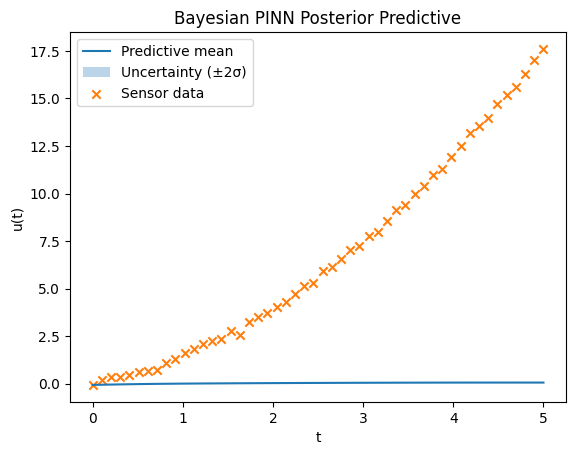

In [59]:
plt.figure()
# predictive mean
plt.plot(t_test.numpy(), u_mean.numpy(), label='Predictive mean')
# ±2σ uncertainty band
plt.fill_between(
    t_test.numpy().ravel(),
    (u_mean - 2*u_std).numpy(),
    (u_mean + 2*u_std).numpy(),
    alpha=0.3,
    label='Uncertainty (±2σ)'
)
# sensor data
plt.scatter(t_data.numpy(), u_data.numpy(), marker='x', label='Sensor data')

plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Bayesian PINN Posterior Predictive')
plt.legend()
plt.show()